# Draft_02

**Course:** Advanced Topics in Deep Learning  
**Topic:** Generative Adversarial Networks (GANs)  
**Authors:** António Cruz (140129), Ricardo Kayseller (95813)

## Conditional GANs on MNIST: From DCGAN Baseline to Stable Conditional Training

### Project Goal
This notebook builds a **Conditional GAN (cGAN)** in **PyTorch** to generate MNIST digits (**0–9**) **conditioned on class labels**.  
Rath

### What We Are Building (High-Level)
We will train two neural networks in an adversarial setup:

- **Generator (G)**: transforms random noise `z` (and a label `y`) into a synthetic image `G(z, y)`.
- **Discriminator (D)**: receives an image `x` and (optionally) a label `y` and outputs a score indicating whether the pair looks **real** or **fake**.

In a **conditional** GAN, the label is part of the input so we can control the output class:
- “Generate a digit **7**” means we sample `z` and set `y=7`.

#### MNIST DataSet
MNIST is a standard benchmark for generative modeling:
- Images are **28×28**, **grayscale**, and have **10 classes** (digits 0–9).
- The dataset is simple enough to train quickly, but still supports meaningful experiments on:
  - **conditional control** (does `y` actually control the digit?),
  - **diversity** (do we avoid mode collapse?),
  - **training stability** (does the GAN converge reliably?).

#### Method Overview 
We will proceed in a structured way:

1. **Data + Preprocessing**
   - Load MNIST and normalize images to **[-1, 1]** (required when using **Tanh** at the generator output).

2. **Baseline: Unconditional DCGAN**
   - Train a standard DCGAN to validate the pipeline and establish a baseline.

3. **Baseline: Conditional GAN (cGAN)**
   - Adapt DCGAN into a cGAN by injecting the label `y` into:
     - **G** (noise + label),
     - **D** (image + label).

4. **Stability Improvements**
   - Apply a practical training recipe and stabilization techniques:
     - **TTUR** (different learning rates for D and G),
     - **Adam** settings commonly used for GANs,
     - **Spectral Normalization** (optional upgrade).

5. **Conditional Quality Upgrade**
   - Implement a stronger conditional discriminator:
     - **Projection Discriminator** (optional upgrade).

6. **Evaluation**
   - Qualitative: controlled sampling grids (fixed `z`, varying `y`, etc.).
   - Quantitative: **label-consistency** using a classifier (MNIST-specific and highly informative).


### 1. Libraries

In [1]:

# Standard library imports
import os
import json
import time
import random
from dataclasses import dataclass, asdict
from typing import Dict, Tuple, Optional, List

# Third-party imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# PyTorch + torchvision 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils import spectral_norm

import torchvision
from torchvision.utils import make_grid, save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

# Evaluation helpers 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Gif
import os, glob
import imageio.v2 as imageio
from IPython.display import Image, display
from PIL import Image


/home/ricarl/env/iscte/taap_p1/.venv_taap_p1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Sanity check: versions + device
print("Python deps loaded successfully.")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == "cuda":
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


Python deps loaded successfully.
torch: 2.10.0+cu130
torchvision: 0.25.0+cu130
numpy: 2.3.5
pandas: 3.0.0
Device: cuda
CUDA device: NVIDIA GeForce RTX 5090


#### 1.1 GPU acceleration configuration

In [3]:
# Automatic Mixed Precision (AMP)
use_amp = True

# cuDNN autotuner (speeds up conv layers for fixed input sizes)
torch.backends.cudnn.benchmark = True

# Enable TensorFloat-32 (TF32) on Ampere+ GPUs for faster matmul/conv (optional, safe for GANs)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
print("TF32 enabled for matmul and cuDNN.")

scaler = torch.amp.GradScaler("cuda", enabled=(use_amp and torch.cuda.is_available()))
print(f"AMP enabled: {use_amp and torch.cuda.is_available()}")

TF32 enabled for matmul and cuDNN.
AMP enabled: True


#### 1.2 Loss and Hyperparameters configuration

### 2. Data Loading 

In [4]:
# Loss variants to compare
LOSS_SET = ["bce", "lsgan", "hinge", "wgan-gp"]

# WGAN-GP specific hyperparameters
LAMBDA_GP = 0.9
N_CRITIC = 5

# Seed + config
SEED = 42

# Dataset
DATASET_PATH = "../../dataset/"
NUM_CLASSES = 10

# Label smoothing (used by BCE / LSGAN)
LABEL_SMOOTHING_REAL = 0.85

# Training
BATCH_SIZE = 512
LATENT_DIM = 100

# Schedule
NUM_STEPS = 15005
SAVE_INTERVAL = 1000

# Run naming
RUN_NAME = "MNIST_GAN_EXP02"

# Evaluation
NUM_EVAL_SAMPLES = 10000   


RUN_DIR = os.path.join("runs", RUN_NAME)
SAMPLES_DIR = os.path.join("samples", RUN_NAME)
CHECKPOINTS_DIR = os.path.join("checkpoints", RUN_NAME)
MODEL_OUTPUT_PATH = os.path.join("model", RUN_NAME)

os.makedirs(RUN_DIR, exist_ok=True)
os.makedirs(SAMPLES_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

print("Config loaded OK.")


Config loaded OK.


In [5]:
import os, json

RUN_DIR = "runs"
os.makedirs(RUN_DIR, exist_ok=True)

config_snapshot = {
    "SEED": SEED,
    "BATCH_SIZE": BATCH_SIZE,
    "LATENT_DIM": LATENT_DIM,
    "NUM_STEPS": NUM_STEPS,
    "SAVE_INTERVAL": SAVE_INTERVAL,
    "LOSS_SET": LOSS_SET,
    "LAMBDA_GP": LAMBDA_GP,
    "N_CRITIC": N_CRITIC,
    "NUM_EVAL_SAMPLES": NUM_EVAL_SAMPLES,
}

with open(os.path.join(RUN_DIR, "config.json"), "w") as f:
    json.dump(config_snapshot, f, indent=2)

print("Config saved:", os.path.join(RUN_DIR, "config.json"))


Config saved: runs/config.json


In [6]:
AUGMENT = False  # <- deixa False para comparar losses de forma justa

if AUGMENT:
    # very mild: tiny translate + tiny rotation, no shear, no scale
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
else:
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root=DATASET_PATH, train=True, download=False, transform=train_transform)
test_dataset  = datasets.MNIST(root=DATASET_PATH, train=False, download=False, transform=test_transform)

NUM_WORKERS = min(4, max(1, (os.cpu_count() or 2) - 1))
PIN_MEMORY = torch.cuda.is_available()
PERSISTENT_WORKERS = True if NUM_WORKERS > 0 else False

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT_WORKERS,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT_WORKERS,
    drop_last=False
)

print("Data loaded OK. AUGMENT =", AUGMENT)

Data loaded OK. AUGMENT = False


### 3. Mini Data Understanding (MNIST)

#### 3.1 Mini data understanding: class distribution (train)

In [7]:
if "train_dataset" in globals():
    labels = train_dataset.targets.numpy()
else:
    _tmp_ds = datasets.MNIST(root=DATASET_PATH, train=True, download=False, transform=None)
    labels = _tmp_ds.targets.numpy()

classes, counts = np.unique(labels, return_counts=True)
freq = counts / counts.sum()

print("Train class distribution:")
for c, n, p in zip(classes, counts, freq):
    print(f"Digit {c}: {n:5d} ({p*100:5.2f}%)")


Train class distribution:
Digit 0:  5923 ( 9.87%)
Digit 1:  6742 (11.24%)
Digit 2:  5958 ( 9.93%)
Digit 3:  6131 (10.22%)
Digit 4:  5842 ( 9.74%)
Digit 5:  5421 ( 9.04%)
Digit 6:  5918 ( 9.86%)
Digit 7:  6265 (10.44%)
Digit 8:  5851 ( 9.75%)
Digit 9:  5949 ( 9.92%)


#### 3.2 Mini data understanding: plot class distribution

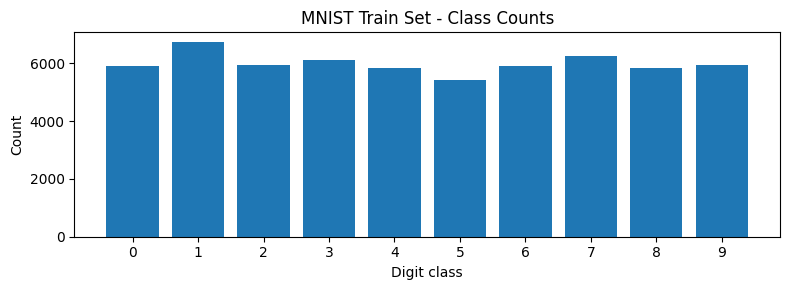

In [8]:
plt.figure(figsize=(8, 3))
plt.bar(classes, counts)
plt.xticks(classes)
plt.title("MNIST Train Set - Class Counts")
plt.xlabel("Digit class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### 3.3 Visualization: real MNIST samples (with de-normalization)

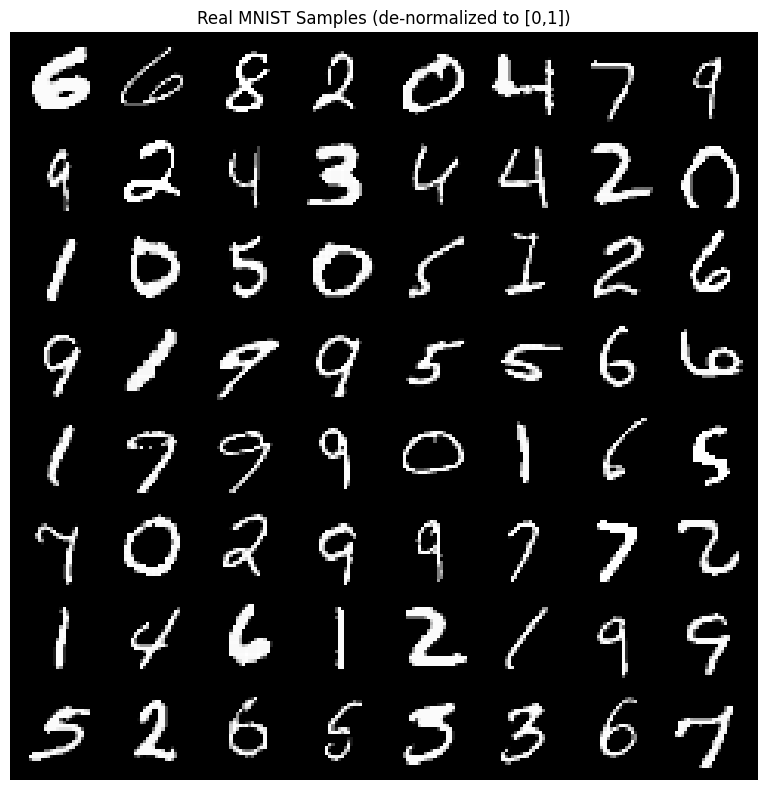

Saved: samples/MNIST_GAN_EXP02/real_mnist_grid.png


In [9]:
# --- Dataset visual sanity-check (PyTorch / torchvision) ---
os.makedirs(SAMPLES_DIR, exist_ok=True)

# Create temp dataset (no transform) if train_dataset is not available
if "train_dataset" in globals():
    _ds = train_dataset
else:
    _ds = datasets.MNIST(root=DATASET_PATH, train=True, download=False, transform=None)

n_show = 64
idx = torch.randint(0, len(_ds), (n_show,))

x_list = []
to_tensor = transforms.ToTensor()  # torchvision (PyTorch ecosystem)

for i in idx.tolist():
    x, _ = _ds[i]
    if not torch.is_tensor(x):      # PIL -> Tensor [0,1]
        x = to_tensor(x)
    # map [0,1] -> [-1,1] so that visualization de-normalization is consistent
    x = (x - 0.5) / 0.5
    x_list.append(x)

x_batch = torch.stack(x_list, dim=0)  # [64,1,28,28]

# De-normalize [-1,1] -> [0,1]
x_vis = (x_batch * 0.5) + 0.5
x_vis = x_vis.clamp(0.0, 1.0)

grid = make_grid(x_vis, nrow=8, padding=2)

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
plt.axis("off")
plt.title("Real MNIST Samples (de-normalized to [0,1])")
plt.tight_layout()
plt.show()

out_path = os.path.join(SAMPLES_DIR, "real_mnist_grid.png")
grid_np = grid.permute(1, 2, 0).cpu().numpy()
if grid_np.shape[2] == 1:
    grid_np = np.repeat(grid_np, 3, axis=2)
plt.imsave(out_path, grid_np)
print(f"Saved: {out_path}")


### 3.4 Samples by class

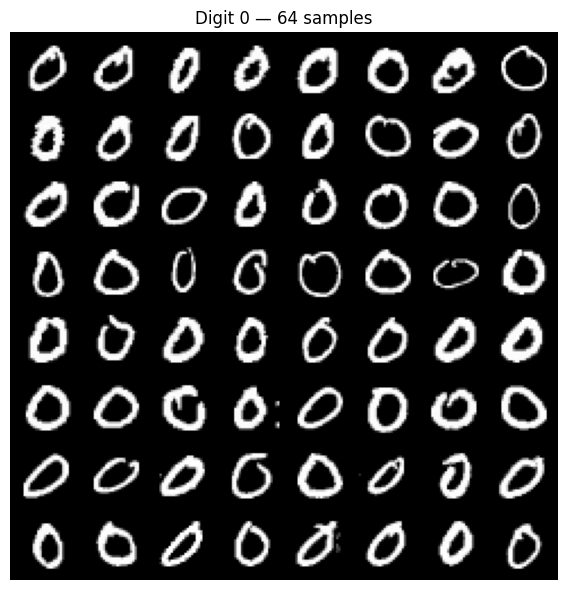

Saved: samples/MNIST_GAN_EXP02/mnist_digit_0_grid.png


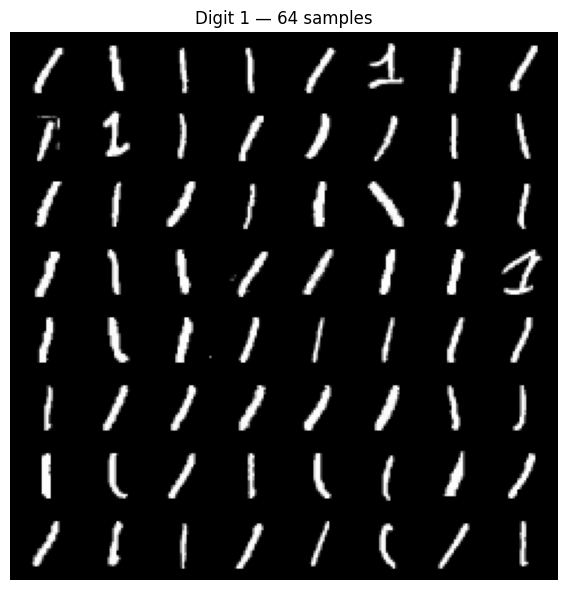

Saved: samples/MNIST_GAN_EXP02/mnist_digit_1_grid.png


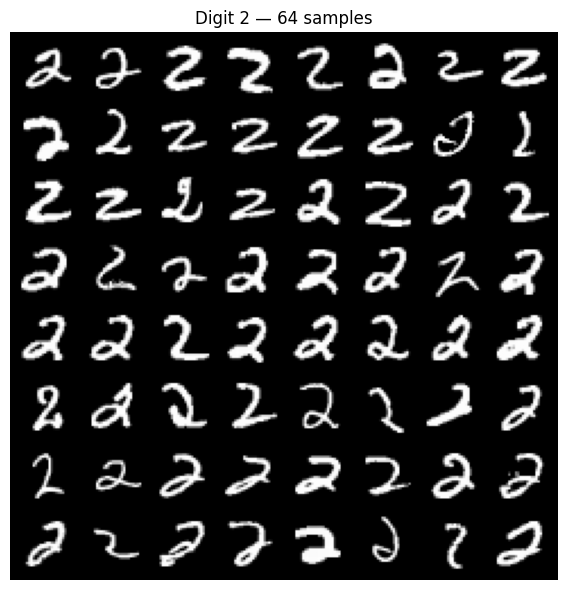

Saved: samples/MNIST_GAN_EXP02/mnist_digit_2_grid.png


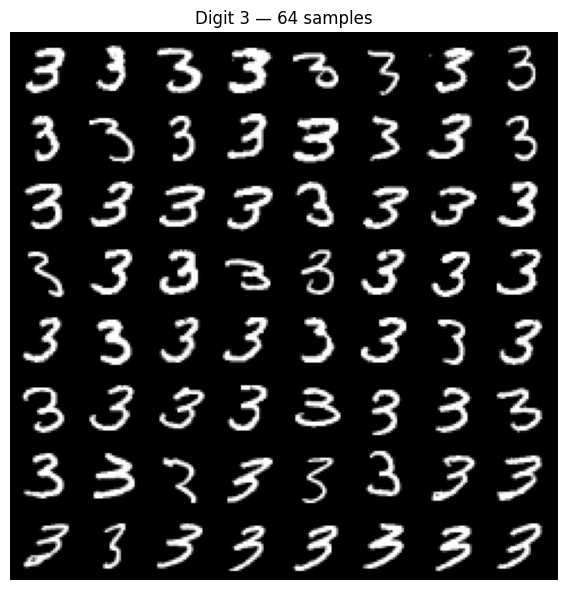

Saved: samples/MNIST_GAN_EXP02/mnist_digit_3_grid.png


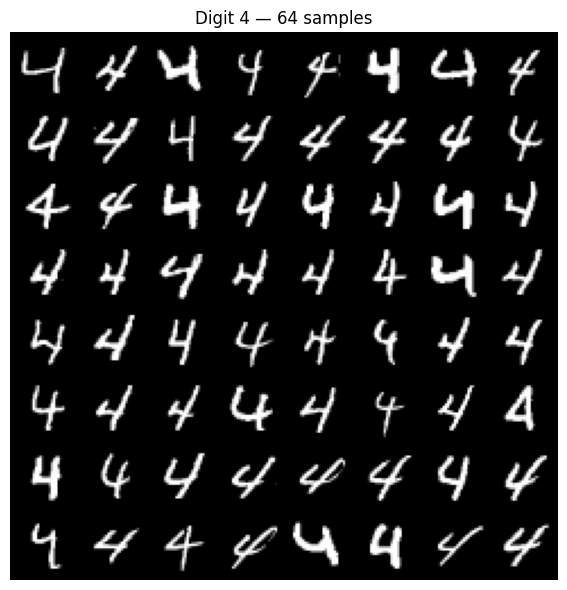

Saved: samples/MNIST_GAN_EXP02/mnist_digit_4_grid.png


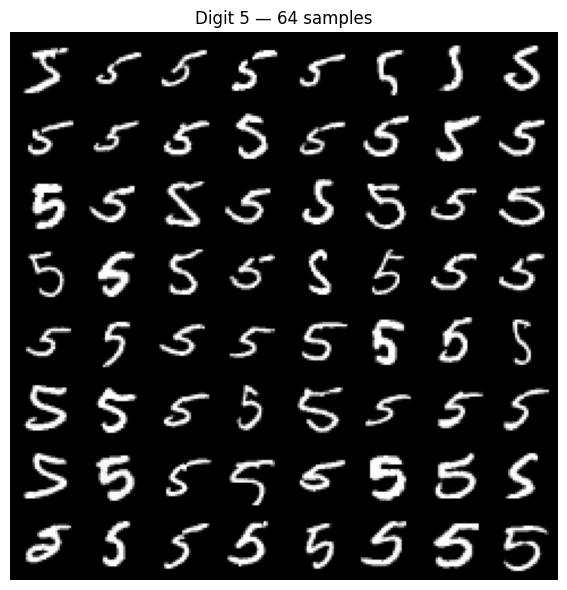

Saved: samples/MNIST_GAN_EXP02/mnist_digit_5_grid.png


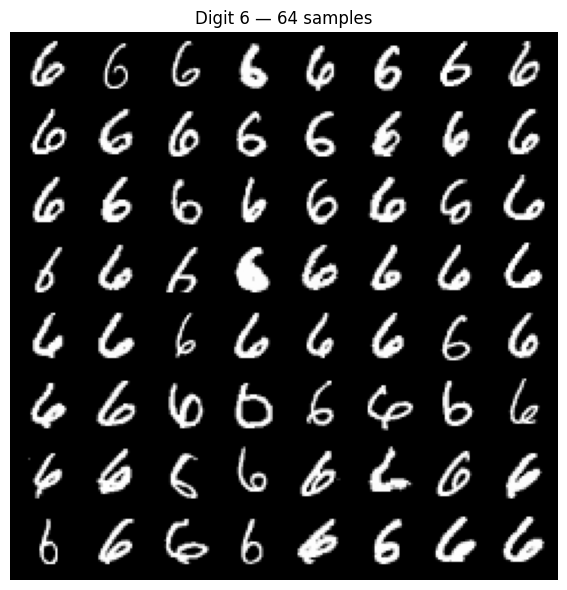

Saved: samples/MNIST_GAN_EXP02/mnist_digit_6_grid.png


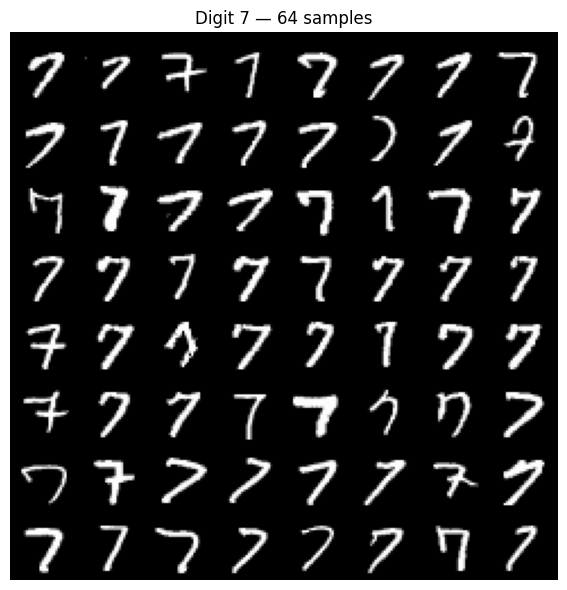

Saved: samples/MNIST_GAN_EXP02/mnist_digit_7_grid.png


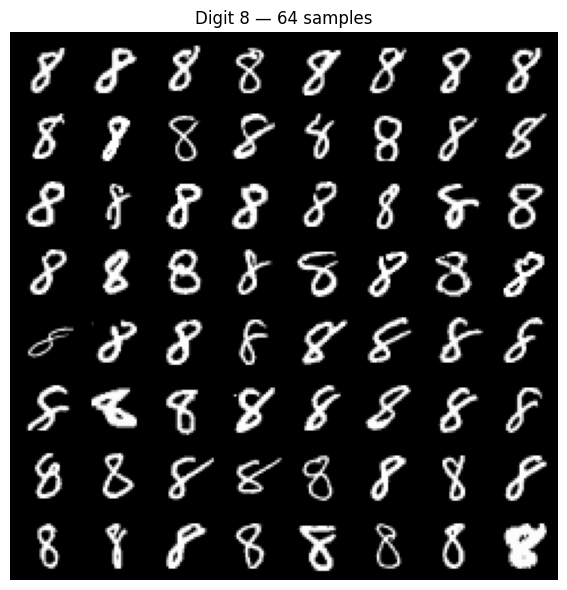

Saved: samples/MNIST_GAN_EXP02/mnist_digit_8_grid.png


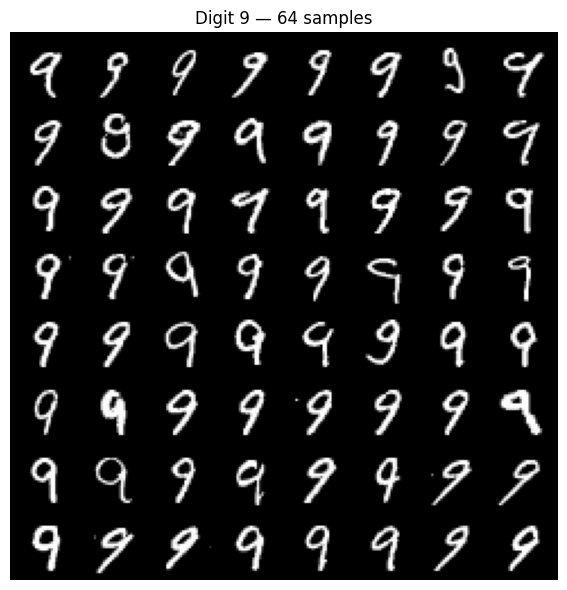

Saved: samples/MNIST_GAN_EXP02/mnist_digit_9_grid.png


In [10]:
# --- Per-digit grids: one image per digit (0..9), each with multiple samples ---
os.makedirs(SAMPLES_DIR, exist_ok=True)

# Use existing train_dataset if available; otherwise load a temp MNIST (no transform)
if "train_dataset" in globals():
    _ds = train_dataset
    has_norm = True  # your train_dataset likely returns normalized [-1,1]
else:
    _ds = datasets.MNIST(root=DATASET_PATH, train=True, download=False, transform=None)
    has_norm = False

to_tensor = transforms.ToTensor()

n_show_per_digit = 64   # how many images per digit grid
nrow = 8                # 8x8 grid if 64
max_scan = 20000        # safety cap on how many items to scan (MNIST is large)

# Collect indices per digit
digit_indices = {d: [] for d in range(10)}

for i in range(min(len(_ds), max_scan)):
    x, y = _ds[i]
    y = int(y)
    if len(digit_indices[y]) < n_show_per_digit:
        digit_indices[y].append(i)

    if all(len(digit_indices[d]) >= n_show_per_digit for d in range(10)):
        break

# Build and save one grid per digit
missing = [d for d in range(10) if len(digit_indices[d]) < n_show_per_digit]
if missing:
    print("Not enough samples collected for digits:", missing)
    print("Try increasing max_scan or reducing n_show_per_digit.")
else:
    for d in range(10):
        # Load images for digit d
        x_list = []
        for idx in digit_indices[d]:
            x, _ = _ds[idx]
            # If PIL image, convert to tensor [0,1]
            if not torch.is_tensor(x):
                x = to_tensor(x)
                # Normalize to [-1,1] to match training visualization
                x = (x - 0.5) / 0.5
            x_list.append(x)

        x_batch = torch.stack(x_list, dim=0)  # [n_show_per_digit, 1, 28, 28]

        # De-normalize [-1,1] -> [0,1]
        x_vis = (x_batch * 0.5) + 0.5
        x_vis = x_vis.clamp(0.0, 1.0)

        grid = make_grid(x_vis, nrow=nrow, padding=2)

        # Save
        out_path = os.path.join(SAMPLES_DIR, f"mnist_digit_{d}_grid.png")
        grid_np = grid.permute(1, 2, 0).cpu().numpy()
        if grid_np.shape[2] == 1:
            grid_np = np.repeat(grid_np, 3, axis=2)
        plt.imsave(out_path, grid_np)

        # Optional: display each grid (comment out if too much output)
        plt.figure(figsize=(6, 6))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
        plt.axis("off")
        plt.title(f"Digit {d} — {n_show_per_digit} samples")
        plt.tight_layout()
        plt.show()

        print(f"Saved: {out_path}")



### 4. Baseline: Unconditional DCGAN (Pipeline Validation)

#### 4.1 Model components: DCGAN Generator

In [11]:
class DCGANGenerator(nn.Module):
    """
    DCGAN-style Generator for MNIST (28x28, 1 channel).
    Input: latent vector z of shape [B, LATENT_DIM, 1, 1]
    Output: generated image of shape [B, 1, 28, 28] in [-1, 1] (Tanh)
    """
    def __init__(self, latent_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            # Input: (B, latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State: (B, 256, 7, 7)

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State: (B, 128, 14, 14)

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State: (B, 64, 28, 28)

            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Tanh()
            # Output: (B, 1, 28, 28) in [-1, 1]
        )

    def forward(self, z):
        return self.net(z)
    
# Weights    
    
def weights_init_dcgan(m: nn.Module):
    classname = m.__class__.__name__

    if "Conv" in classname or "Linear" in classname:
        # spectral_norm wraps weights into weight_orig
        if hasattr(m, "weight_orig") and m.weight_orig is not None:
            nn.init.normal_(m.weight_orig.data, 0.0, 0.02)
        elif hasattr(m, "weight") and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)

        if hasattr(m, "bias") and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

    elif "BatchNorm" in classname:
        if hasattr(m, "weight") and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)



#### 4.2 Model components: DCGAN Discriminator

In [12]:
# -------------------------
# MNIST Discriminator (SN) for BCE/LSGAN/Hinge
# Input: [B,1,28,28] -> output logits [B,1]
# -------------------------
class DiscriminatorSN(nn.Module):
    def __init__(self, use_sigmoid: bool = False, p_drop: float = 0.0):
        super().__init__()
        self.use_sigmoid = use_sigmoid

        self.net = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)),  # 28->14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p_drop) if p_drop > 0 else nn.Identity(),

            spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),  # 14->7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p_drop) if p_drop > 0 else nn.Identity(),

            nn.Flatten(),  # 128*7*7
            spectral_norm(nn.Linear(128 * 7 * 7, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p_drop) if p_drop > 0 else nn.Identity(),

            spectral_norm(nn.Linear(256, 1)),  # logits
        )

    def forward(self, x):
        x = self.net(x)
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        return x


# -------------------------
# WGAN-GP Critic (NO SN, NO Dropout, NO BatchNorm)
# Input: [B,1,28,28] -> raw score [B,1]
# -------------------------
class DCGANCriticWGAN(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()

        self.c1 = nn.Conv2d(in_channels, 64, 4, 2, 1)        # 28 -> 14
        self.ln1 = nn.LayerNorm([64, 14, 14])

        self.c2 = nn.Conv2d(64, 128, 4, 2, 1)               # 14 -> 7
        self.ln2 = nn.LayerNorm([128, 7, 7])

        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.ln3 = nn.LayerNorm(256)

        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.leaky_relu(self.ln1(self.c1(x)), 0.2)
        x = F.leaky_relu(self.ln2(self.c2(x)), 0.2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.ln3(self.fc1(x)), 0.2)
        return self.fc2(x)  # raw score


def get_discriminator(loss_type: str, device):
    if loss_type == "wgan-gp":
        return DCGANCriticWGAN(in_channels=1).to(device)  # MNIST = 1 channel
    return DiscriminatorSN(use_sigmoid=False, p_drop=0.0).to(device)


#### 4.4 Instantiate models + move to device

In [13]:
def apply_dcgan_init_sn_aware(model: nn.Module):
    """
    Applies DCGAN init safely even when spectral_norm is used.
    - If a module has `weight_orig` (spectral_norm wrapped), init that.
    - Else, init `weight`.
    """
    for m in model.modules():
        classname = m.__class__.__name__

        # Conv / ConvTranspose / Linear
        if "Conv" in classname or "Linear" in classname:
            if hasattr(m, "weight_orig") and m.weight_orig is not None:
                nn.init.normal_(m.weight_orig.data, 0.0, 0.02)
            elif hasattr(m, "weight") and m.weight is not None:
                nn.init.normal_(m.weight.data, 0.0, 0.02)

            if hasattr(m, "bias") and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)

        # BatchNorm
        elif "BatchNorm" in classname:
            if hasattr(m, "weight") and m.weight is not None:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
            if hasattr(m, "bias") and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)


In [14]:
# --- Sanity check: instantiate models for ONE loss_type ---
loss_type = "bce"  # "lsgan" | "hinge" | "wgan-gp"

# Generator
G = DCGANGenerator(LATENT_DIM).to(device)
apply_dcgan_init_sn_aware(G)   # init DCGAN-style (safe)

# Discriminator / Critic
D = get_discriminator(loss_type, device)

# Init D too (SN-aware handles spectral_norm; LN is fine)
apply_dcgan_init_sn_aware(D)

print("loss_type =", loss_type)
print(G)
print(D)




loss_type = bce
DCGANGenerator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)
DiscriminatorSN(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Identity()
    (3): Conv2d(64, 128, kernel_siz

#### 4.4 DCGAN optimizers (TTUR)

In [15]:
# --- AMP + Optimizer defaults (used by all runs) ---
use_amp = True

# TTUR learning rates (good default for GANs)
LR_G = 1e-4
LR_D = 4e-4

# WGAN-GP: commonly uses equal lrs
LR_G_WGAN = 1e-4
LR_D_WGAN = 2e-4

# Default betas (BCE/LSGAN/Hinge)
BETAS_DEFAULT = (0.5, 0.999)

# WGAN-GP recommended-ish betas
BETAS_WGAN = (0.0, 0.9)


def make_optimizers(G, D, loss_type: str,
                    lr_g: float = None, lr_d: float = None):
    loss_type = loss_type.lower()

    if loss_type == "wgan-gp":
        betas = BETAS_WGAN
        lr_g = LR_G_WGAN if lr_g is None else lr_g
        lr_d = LR_D_WGAN if lr_d is None else lr_d
    else:
        betas = BETAS_DEFAULT
        lr_g = LR_G_DEFAULT if lr_g is None else lr_g
        lr_d = LR_D_DEFAULT if lr_d is None else lr_d

    opt_G = torch.optim.Adam(G.parameters(), lr=lr_g, betas=betas)
    opt_D = torch.optim.Adam(D.parameters(), lr=lr_d, betas=betas)
    return opt_G, opt_D


def use_amp_for_loss(loss_type: str) -> bool:
    # AMP + gradient penalty is a common source of NaNs in practice :contentReference[oaicite:6]{index=6}
    return (loss_type.lower() != "wgan-gp") and use_amp


#### 4.5 Loss Factory and GP

In [16]:
# --- Loss helpers (init once for efficiency) ---
_bce_logits = nn.BCEWithLogitsLoss()

def gradient_penalty(D, real, fake, device, use_fp32: bool = True):
    """
    WGAN-GP gradient penalty:
    GP = E[(||∇_x D(x_hat)||_2 - 1)^2], with x_hat interpolated between real and fake.
    Computing GP in fp32 improves stability when AMP is enabled.
    """
    B = real.size(0)
    eps = torch.rand(B, 1, 1, 1, device=device)
    interp = eps * real + (1.0 - eps) * fake
    interp.requires_grad_(True)

    if use_fp32:
        # Stabilize GP under AMP: do the critic forward + grad in fp32
        interp_ = interp.float()
        d_interp = D(interp_).float()
    else:
        d_interp = D(interp)

    grads = torch.autograd.grad(
        outputs=d_interp,
        inputs=interp if not use_fp32 else interp_,
        grad_outputs=torch.ones_like(d_interp),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grads = grads.view(B, -1)
    gp = ((grads.norm(2, dim=1) - 1.0) ** 2).mean()
    return gp


def compute_d_loss(loss_type, D, real, fake, device, gp_fp32: bool = True):
    d_real = D(real)
    d_fake = D(fake.detach())

    if loss_type == "bce":
        # label smoothing only on REAL
        ones = torch.full_like(d_real, LABEL_SMOOTHING_REAL)
        zeros = torch.zeros_like(d_fake)
        loss_D = _bce_logits(d_real, ones) + _bce_logits(d_fake, zeros)
        stats = {
            "D_real_mean": torch.sigmoid(d_real).mean().item(),
            "D_fake_mean": torch.sigmoid(d_fake).mean().item(),
        }

    elif loss_type == "lsgan":
        # LSGAN targets: real=b, fake=a (classic uses b=1, a=0)
        b = LABEL_SMOOTHING_REAL
        a = 0.0
        loss_D = 0.5 * (((d_real - b) ** 2).mean() + ((d_fake - a) ** 2).mean())
        stats = {"D_real_mean": d_real.mean().item(), "D_fake_mean": d_fake.mean().item()}

    elif loss_type == "hinge":
        loss_D = torch.mean(F.relu(1.0 - d_real)) + torch.mean(F.relu(1.0 + d_fake))
        stats = {"D_real_mean": d_real.mean().item(), "D_fake_mean": d_fake.mean().item()}

    elif loss_type == "wgan-gp":
        gp = gradient_penalty(D, real, fake.detach(), device=device, use_fp32=gp_fp32)
        loss_D = d_fake.mean() - d_real.mean() + LAMBDA_GP * gp
        stats = {
            "D_real_mean": d_real.mean().item(),
            "D_fake_mean": d_fake.mean().item(),
            "gp": gp.item()
        }

    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")

    return loss_D, stats


def compute_g_loss(loss_type, D, fake):
    d_fake = D(fake)

    if loss_type == "bce":
        ones = torch.ones_like(d_fake)
        return _bce_logits(d_fake, ones)

    if loss_type == "lsgan":
        # keep generator target consistent with "real" target (classic c=1, or c=b if smoothing)
        c = 1.0
        return 0.5 * ((d_fake - c) ** 2).mean()

    if loss_type == "hinge":
        return -torch.mean(d_fake)

    if loss_type == "wgan-gp":
        return -torch.mean(d_fake)

    raise ValueError(f"Unknown loss_type: {loss_type}")


In [17]:
from torchvision.utils import make_grid, save_image

@torch.no_grad()
def sample_dcgan_grid(
    G: torch.nn.Module,
    step: int,
    device: torch.device,
    latent_dim: int,
    n_samples: int = 64,
    nrow: int = 8,
    out_dir: str = "samples/dcgan",
    fixed_z: torch.Tensor | None = None
):
    os.makedirs(out_dir, exist_ok=True)

    was_training = G.training
    G.eval()

    if fixed_z is None:
        z = torch.randn(n_samples, latent_dim, 1, 1, device=device)
    else:
        z = fixed_z.to(device)

    fake = G(z)

    # [-1,1] -> [0,1]
    fake_vis = (fake * 0.5) + 0.5
    fake_vis = fake_vis.clamp(0.0, 1.0)

    out_path = os.path.join(out_dir, f"step_{step:06d}.png")

    # save_image is simpler and reliable for grayscale
    save_image(fake_vis, out_path, nrow=nrow, padding=2)

    if was_training:
        G.train()

    # If you still want the grid tensor:
    grid = make_grid(fake_vis, nrow=nrow, padding=2)
    return out_path, grid



In [18]:
class MNISTFeatureNet(nn.Module):
    """
    Simple MNIST feature extractor.
    Output: 128-dim embedding (used for FID/KID).
    """
    def __init__(self, emb_dim=128, num_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.fc_feat = nn.Linear(64 * 7 * 7, emb_dim)
        self.fc_cls  = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        h = self.conv(x)
        h = h.flatten(1)
        feat = self.fc_feat(h)
        logits = self.fc_cls(F.relu(feat))
        return feat, logits


def train_feature_net(train_loader, device, epochs=2, lr=1e-3):
    """
    Train a small MNIST classifier quickly to get meaningful embeddings.
    IMPORTANT: expects inputs in [0,1].
    """
    net = MNISTFeatureNet().to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    net.train()

    for ep in range(epochs):
        correct, total = 0, 0
        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # train_loader gives x in [-1,1]; convert to [0,1]
            x = (x * 0.5 + 0.5).clamp(0, 1)

            feat, logits = net(x)
            loss = F.cross_entropy(logits, y)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.numel()

        acc = correct / total
        print(f"[FeatureNet] epoch {ep+1}/{epochs} | acc={acc:.4f}")

    net.eval()
    for p in net.parameters():
        p.requires_grad_(False)
    return net


# Train once (run this cell once)
feature_net = train_feature_net(train_loader, device, epochs=2, lr=1e-3)


[FeatureNet] epoch 1/2 | acc=0.9202
[FeatureNet] epoch 2/2 | acc=0.9808


In [19]:
@torch.no_grad()
def extract_real_features(feature_net, train_loader, device, n_samples=10000):
    feats = []
    seen = 0
    for x, _ in train_loader:
        x = x.to(device, non_blocking=True)
        x = (x * 0.5 + 0.5).clamp(0, 1)  # [-1,1] -> [0,1]
        f, _ = feature_net(x)
        feats.append(f.float().cpu())
        seen += x.size(0)
        if seen >= n_samples:
            break
    feats = torch.cat(feats, dim=0)[:n_samples]
    return feats


@torch.no_grad()
def extract_fake_features(feature_net, G, device, latent_dim, n_samples=10000, batch_size=512):
    feats = []
    seen = 0
    G.eval()
    while seen < n_samples:
        bs = min(batch_size, n_samples - seen)
        z = torch.randn(bs, latent_dim, 1, 1, device=device)
        fake = G(z)                      # [-1,1]
        fake = (fake * 0.5 + 0.5).clamp(0, 1)  # -> [0,1]
        f, _ = feature_net(fake)
        feats.append(f.float().cpu())
        seen += bs
    G.train()
    return torch.cat(feats, dim=0)


def _cov(feats: torch.Tensor):
    # feats: [N, D]
    feats = feats.double()
    mu = feats.mean(dim=0, keepdim=True)
    xc = feats - mu
    cov = (xc.t() @ xc) / (feats.size(0) - 1)
    return mu.squeeze(0), cov


def fid_torch(real_feats: torch.Tensor, fake_feats: torch.Tensor, eps=1e-6) -> float:
    """
    FID computed with eigendecomposition (PyTorch), no scipy.
    """
    mu_r, sigma_r = _cov(real_feats)
    mu_f, sigma_f = _cov(fake_feats)

    diff = (mu_r - mu_f)
    diff_sq = diff @ diff

    # product may be non-symmetric due to numeric issues; symmetrize
    cov_prod = sigma_r @ sigma_f
    cov_prod = (cov_prod + cov_prod.t()) * 0.5

    # eigen decomposition
    eigvals, eigvecs = torch.linalg.eigh(cov_prod)
    eigvals = torch.clamp(eigvals, min=eps)
    sqrt_cov_prod = eigvecs @ torch.diag(torch.sqrt(eigvals)) @ eigvecs.t()

    fid = diff_sq + torch.trace(sigma_r + sigma_f - 2.0 * sqrt_cov_prod)
    return float(fid.item())


def kid_torch_unbiased(
    real_feats: torch.Tensor,
    fake_feats: torch.Tensor,
    degree: int = 3,
    gamma: float | None = None,
    coef0: float = 1.0,
    n_subsets: int = 10,
    subset_size: int = 1000,
    seed: int = 42,
):
    """
    KID = polynomial MMD (UNBIASED estimator).
    Returns (mean, std) across subsets.
    """
    rng = torch.Generator().manual_seed(seed)

    real = real_feats.float()
    fake = fake_feats.float()

    D = real.size(1)
    if gamma is None:
        gamma = 1.0 / D

    kids = []
    for _ in range(n_subsets):
        idx_r = torch.randperm(real.size(0), generator=rng)[:subset_size]
        idx_f = torch.randperm(fake.size(0), generator=rng)[:subset_size]
        x = real[idx_r]  # [m, D]
        y = fake[idx_f]  # [m, D]
        m = x.size(0)

        K_xx = (gamma * (x @ x.t()) + coef0).pow(degree)
        K_yy = (gamma * (y @ y.t()) + coef0).pow(degree)
        K_xy = (gamma * (x @ y.t()) + coef0).pow(degree)

        # UNBIASED: remove diagonal in xx/yy
        sum_xx = (K_xx.sum() - K_xx.diag().sum()) / (m * (m - 1))
        sum_yy = (K_yy.sum() - K_yy.diag().sum()) / (m * (m - 1))
        sum_xy = K_xy.mean()  # 1/(m*m)

        mmd2 = sum_xx + sum_yy - 2.0 * sum_xy
        kids.append(mmd2.item())

    kids = torch.tensor(kids)
    return float(kids.mean().item()), float(kids.std(unbiased=False).item())


@torch.no_grad()
def evaluate_fid_kid(G, feature_net, train_loader, device, latent_dim, n_samples=10000):
    real_feats = extract_real_features(feature_net, train_loader, device, n_samples=n_samples)
    fake_feats = extract_fake_features(feature_net, G, device, latent_dim, n_samples=n_samples)

    fid = fid_torch(real_feats, fake_feats)
    kid_mean, kid_std = kid_torch_unbiased(real_feats, fake_feats, n_subsets=10, subset_size=1000)
    return fid, kid_mean, kid_std


#### 4.6 DCGAN training loop (step-based)

In [20]:
import time
from tqdm import tqdm

def train_dcgan(loss_type: str):
    print(f"\n=== Training DCGAN | loss={loss_type} ===")

    t0 = time.time()
    set_seed(SEED)

    # ===== Models =====
    G = DCGANGenerator(LATENT_DIM).to(device)
    D = get_discriminator(loss_type, device)

    G.apply(weights_init_dcgan)
    D.apply(weights_init_dcgan)

    # ===== Optimizers (strategy-aware betas) =====
    if loss_type == "wgan-gp":
        betas = (0.0, 0.9)
    else:
        betas = BETAS_DEFAULT  # expected (0.5, 0.999)

    opt_G = torch.optim.Adam(G.parameters(), lr=LR_G, betas=betas)
    opt_D = torch.optim.Adam(D.parameters(), lr=LR_D, betas=betas)

    # AMP (only for non-WGAN-GP; GP is sensitive in FP16)
    scaler = torch.amp.GradScaler("cuda", enabled=(use_amp and device.type == "cuda" and loss_type != "wgan-gp"))

    log_rows = []
    global_step = 0
    pbar = tqdm(total=NUM_STEPS, desc=f"DCGAN [{loss_type}]")

    while global_step < NUM_STEPS:
        for real, _ in train_loader:
            if global_step >= NUM_STEPS:
                break

            real = real.to(device, non_blocking=True)
            B = real.size(0)

            # =========================================================
            # WGAN-GP: train Critic N_CRITIC times per 1 G update
            # =========================================================
            if loss_type == "wgan-gp":
                last_stats = {}

                # ---- Critic updates ----
                for _ in range(N_CRITIC):
                    opt_D.zero_grad(set_to_none=True)

                    z = torch.randn(B, LATENT_DIM, 1, 1, device=device)
                    fake = G(z).detach()

                    # Disable autocast for GP stability
                    with torch.amp.autocast("cuda", enabled=False):
                        loss_D, stats = compute_d_loss(loss_type, D, real, fake, device)

                    loss_D.backward()
                    opt_D.step()
                    last_stats = stats

                # ---- Generator update (1 step) ----
                opt_G.zero_grad(set_to_none=True)
                z = torch.randn(B, LATENT_DIM, 1, 1, device=device)
                fake = G(z)

                with torch.amp.autocast("cuda", enabled=False):
                    loss_G = compute_g_loss(loss_type, D, fake)

                loss_G.backward()
                opt_G.step()

                stats = last_stats  # keep last critic stats for logging

            # =========================================================
            # BCE / LSGAN / Hinge: 1 D step + 1 G step (AMP allowed)
            # =========================================================
            else:
                # ===== Train Discriminator =====
                opt_D.zero_grad(set_to_none=True)
                z = torch.randn(B, LATENT_DIM, 1, 1, device=device)
                fake = G(z).detach()

                with torch.amp.autocast("cuda", enabled=(use_amp and device.type == "cuda")):
                    loss_D, stats = compute_d_loss(loss_type, D, real, fake, device)

                scaler.scale(loss_D).backward()
                scaler.step(opt_D)

                # ===== Train Generator =====
                opt_G.zero_grad(set_to_none=True)
                z = torch.randn(B, LATENT_DIM, 1, 1, device=device)
                fake = G(z)

                with torch.amp.autocast("cuda", enabled=(use_amp and device.type == "cuda")):
                    loss_G = compute_g_loss(loss_type, D, fake)

                scaler.scale(loss_G).backward()
                scaler.step(opt_G)
                scaler.update()

            # ===== Logging =====
            if global_step % 50 == 0:
                row = {
                    "step": global_step,
                    "loss_D": float(loss_D.detach().cpu().item()),
                    "loss_G": float(loss_G.detach().cpu().item()) if torch.isfinite(loss_G) else np.nan,
                }
                if isinstance(stats, dict):
                    row.update(stats)
                log_rows.append(row)

            # ===== Sampling =====
            if global_step % SAVE_INTERVAL == 0:
                out_path, _ = sample_dcgan_grid(
                    G=G,
                    step=global_step,
                    device=device,
                    latent_dim=LATENT_DIM,
                    out_dir=f"samples/dcgan/{loss_type}"
                )
                print(f"[{loss_type} | step {global_step}] Saved: {out_path}")

            global_step += 1
            pbar.update(1)

    pbar.close()

    # ===== Save logs =====
    df = pd.DataFrame(log_rows)
    os.makedirs("runs", exist_ok=True)
    log_path = f"runs/dcgan_{loss_type}_log.csv"
    df.to_csv(log_path, index=False)
    print(f"Saved log: {log_path}")

    # ===== Plots at the end =====
    def plot_end(df, loss_type):
        # 1) Loss curves
        plt.figure(figsize=(8, 4))
        plt.plot(df["step"], df["loss_D"], label="D loss")
        plt.plot(df["step"], df["loss_G"], label="G loss")
        plt.xlabel("Training step")
        plt.ylabel("Loss")
        plt.title(f"DCGAN ({loss_type}) - Loss Curves")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # 2) D score monitoring
        if "D_real_mean" in df.columns and "D_fake_mean" in df.columns:
            plt.figure(figsize=(8, 4))
            plt.plot(df["step"], df["D_real_mean"], label="D(real) mean")
            plt.plot(df["step"], df["D_fake_mean"], label="D(fake) mean")
            plt.xlabel("Training step")
            plt.ylabel("Score")
            plt.title(f"DCGAN ({loss_type}) - D Score Monitoring")
            plt.legend()
            plt.tight_layout()
            plt.show()

        # 3) Gradient penalty (WGAN-GP)
        if "gp" in df.columns:
            plt.figure(figsize=(8, 4))
            plt.plot(df["step"], df["gp"], label="Gradient Penalty")
            plt.xlabel("Training step")
            plt.ylabel("GP")
            plt.title(f"DCGAN ({loss_type}) - Gradient Penalty")
            plt.legend()
            plt.tight_layout()
            plt.show()

    plot_end(df, loss_type)

    # ===== Evaluation: FID / KID =====
    # NOTE: feature_net must already exist.
    # NOTE: evaluate_fid_kid must already exist.
    G_was_training = G.training
    G.eval()
    with torch.no_grad():
        fid, kid_mean, kid_std = evaluate_fid_kid(
            G=G,
            feature_net=feature_net,
            train_loader=train_loader,
            device=device,
            latent_dim=LATENT_DIM,
            n_samples=NUM_EVAL_SAMPLES
        )
    if G_was_training:
        G.train()

    # ===== Extra analysis: training stability (lower is better) =====
    lossD_std = float(np.nanstd(df["loss_D"].to_numpy(dtype=float)))
    lossG_std = float(np.nanstd(df["loss_G"].to_numpy(dtype=float)))

    elapsed = time.time() - t0

    print(f"\n[{loss_type}] Evaluation summary:")
    print(f"  FID: {float(fid):.3f} (lower better)")
    print(f"  KID: {float(kid_mean):.6f} ± {float(kid_std):.6f} (lower better)")
    print(f"  Stability: std(loss_D)={lossD_std:.4f} | std(loss_G)={lossG_std:.4f} (lower better)")
    print(f"  Runtime: {elapsed/60:.2f} min")

    # ===== Save a one-line summary (append) =====
    summary_path = "runs/dcgan_metrics_summary.csv"
    os.makedirs(os.path.dirname(summary_path), exist_ok=True)

    row = pd.DataFrame([{
        "loss_type": str(loss_type),
        "FID": float(fid),
        "KID_mean": float(kid_mean),
        "KID_std": float(kid_std),
        "lossD_std": lossD_std,
        "lossG_std": lossG_std,
        "runtime_sec": float(elapsed),
    }])

    write_header = not os.path.exists(summary_path)
    row.to_csv(summary_path, mode="a", header=write_header, index=False)
    print(f"Saved summary row: {summary_path}")

    return G, D, df


In [21]:
summary_path = "runs/dcgan_metrics_summary.csv"
if os.path.exists(summary_path):
    os.remove(summary_path)
    print("Removed old summary:", summary_path)
else:
    print("No previous summary found.")

Removed old summary: runs/dcgan_metrics_summary.csv



=== Training DCGAN | loss=bce ===


DCGAN [bce]:   0%|          | 7/15005 [00:00<26:09,  9.56it/s]  

[bce | step 0] Saved: samples/dcgan/bce/step_000000.png


DCGAN [bce]:   7%|▋         | 1010/15005 [00:17<03:43, 62.66it/s]

[bce | step 1000] Saved: samples/dcgan/bce/step_001000.png


DCGAN [bce]:  13%|█▎        | 2010/15005 [00:34<03:43, 58.11it/s]

[bce | step 2000] Saved: samples/dcgan/bce/step_002000.png


DCGAN [bce]:  20%|██        | 3009/15005 [00:50<03:20, 59.83it/s]

[bce | step 3000] Saved: samples/dcgan/bce/step_003000.png


DCGAN [bce]:  27%|██▋       | 4007/15005 [01:07<03:01, 60.71it/s]

[bce | step 4000] Saved: samples/dcgan/bce/step_004000.png


DCGAN [bce]:  33%|███▎      | 5009/15005 [01:23<02:37, 63.30it/s]

[bce | step 5000] Saved: samples/dcgan/bce/step_005000.png


DCGAN [bce]:  40%|████      | 6011/15005 [01:40<02:34, 58.04it/s]

[bce | step 6000] Saved: samples/dcgan/bce/step_006000.png


DCGAN [bce]:  47%|████▋     | 7008/15005 [01:56<02:09, 61.88it/s]

[bce | step 7000] Saved: samples/dcgan/bce/step_007000.png


DCGAN [bce]:  53%|█████▎    | 8009/15005 [02:13<01:55, 60.33it/s]

[bce | step 8000] Saved: samples/dcgan/bce/step_008000.png


DCGAN [bce]:  60%|██████    | 9007/15005 [02:29<01:38, 61.04it/s]

[bce | step 9000] Saved: samples/dcgan/bce/step_009000.png


DCGAN [bce]:  67%|██████▋   | 10011/15005 [02:45<01:15, 66.14it/s]

[bce | step 10000] Saved: samples/dcgan/bce/step_010000.png


DCGAN [bce]:  73%|███████▎  | 11011/15005 [03:01<01:06, 60.27it/s]

[bce | step 11000] Saved: samples/dcgan/bce/step_011000.png


DCGAN [bce]:  80%|████████  | 12008/15005 [03:17<00:56, 53.09it/s]

[bce | step 12000] Saved: samples/dcgan/bce/step_012000.png


DCGAN [bce]:  87%|████████▋ | 13009/15005 [03:33<00:32, 62.17it/s]

[bce | step 13000] Saved: samples/dcgan/bce/step_013000.png


DCGAN [bce]:  93%|█████████▎| 14011/15005 [03:49<00:16, 62.04it/s]

[bce | step 14000] Saved: samples/dcgan/bce/step_014000.png


DCGAN [bce]: 100%|██████████| 15005/15005 [04:05<00:00, 61.22it/s]

[bce | step 15000] Saved: samples/dcgan/bce/step_015000.png
Saved log: runs/dcgan_bce_log.csv


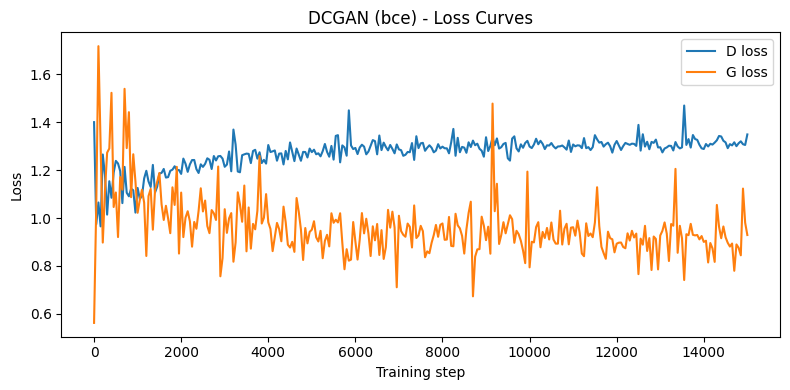

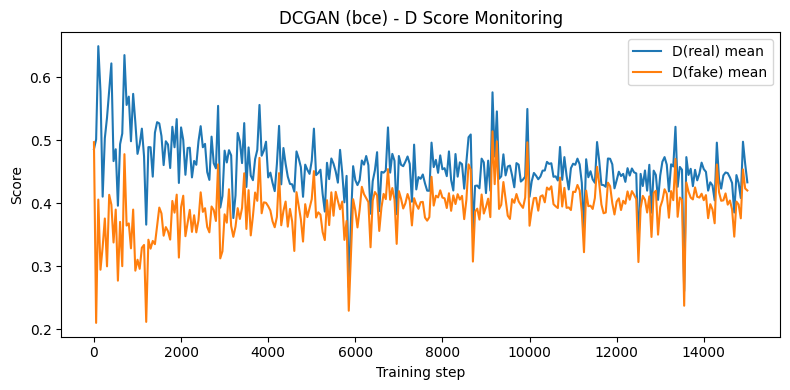


[bce] Evaluation summary:
  FID: 8.858 (lower better)
  KID: 11.363134 ± 11.209501 (lower better)
  Stability: std(loss_D)=0.0658 | std(loss_G)=0.1269 (lower better)
  Runtime: 4.09 min
Saved summary row: runs/dcgan_metrics_summary.csv

=== Training DCGAN | loss=lsgan ===


DCGAN [lsgan]:   0%|          | 2/15005 [00:00<13:57, 17.92it/s]

[lsgan | step 0] Saved: samples/dcgan/lsgan/step_000000.png


DCGAN [lsgan]:   7%|▋         | 1013/15005 [00:16<03:59, 58.43it/s]

[lsgan | step 1000] Saved: samples/dcgan/lsgan/step_001000.png


DCGAN [lsgan]:  13%|█▎        | 2009/15005 [00:34<04:01, 53.76it/s]

[lsgan | step 2000] Saved: samples/dcgan/lsgan/step_002000.png


DCGAN [lsgan]:  20%|██        | 3011/15005 [00:52<03:28, 57.43it/s]

[lsgan | step 3000] Saved: samples/dcgan/lsgan/step_003000.png


DCGAN [lsgan]:  27%|██▋       | 4009/15005 [01:09<03:08, 58.49it/s]

[lsgan | step 4000] Saved: samples/dcgan/lsgan/step_004000.png


DCGAN [lsgan]:  33%|███▎      | 5007/15005 [01:26<02:51, 58.32it/s]

[lsgan | step 5000] Saved: samples/dcgan/lsgan/step_005000.png


DCGAN [lsgan]:  40%|████      | 6012/15005 [01:42<02:27, 60.90it/s]

[lsgan | step 6000] Saved: samples/dcgan/lsgan/step_006000.png


DCGAN [lsgan]:  47%|████▋     | 7013/15005 [01:59<02:07, 62.83it/s]

[lsgan | step 7000] Saved: samples/dcgan/lsgan/step_007000.png


DCGAN [lsgan]:  53%|█████▎    | 8008/15005 [02:15<01:51, 62.60it/s]

[lsgan | step 8000] Saved: samples/dcgan/lsgan/step_008000.png


DCGAN [lsgan]:  60%|██████    | 9007/15005 [02:31<01:43, 57.74it/s]

[lsgan | step 9000] Saved: samples/dcgan/lsgan/step_009000.png


DCGAN [lsgan]:  67%|██████▋   | 10007/15005 [02:47<01:25, 58.56it/s]

[lsgan | step 10000] Saved: samples/dcgan/lsgan/step_010000.png


DCGAN [lsgan]:  73%|███████▎  | 11012/15005 [03:04<01:09, 57.56it/s]

[lsgan | step 11000] Saved: samples/dcgan/lsgan/step_011000.png


DCGAN [lsgan]:  80%|████████  | 12009/15005 [03:21<00:50, 59.07it/s]

[lsgan | step 12000] Saved: samples/dcgan/lsgan/step_012000.png


DCGAN [lsgan]:  87%|████████▋ | 13008/15005 [03:37<00:34, 58.11it/s]

[lsgan | step 13000] Saved: samples/dcgan/lsgan/step_013000.png


DCGAN [lsgan]:  93%|█████████▎| 14010/15005 [03:54<00:17, 57.17it/s]

[lsgan | step 14000] Saved: samples/dcgan/lsgan/step_014000.png


DCGAN [lsgan]: 100%|██████████| 15005/15005 [04:10<00:00, 59.85it/s]

[lsgan | step 15000] Saved: samples/dcgan/lsgan/step_015000.png
Saved log: runs/dcgan_lsgan_log.csv


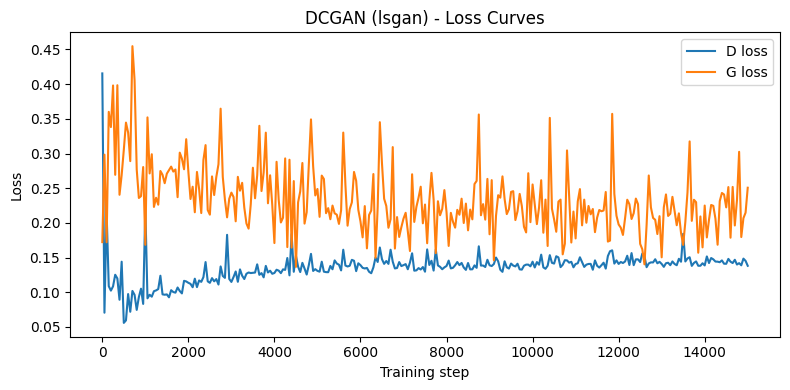

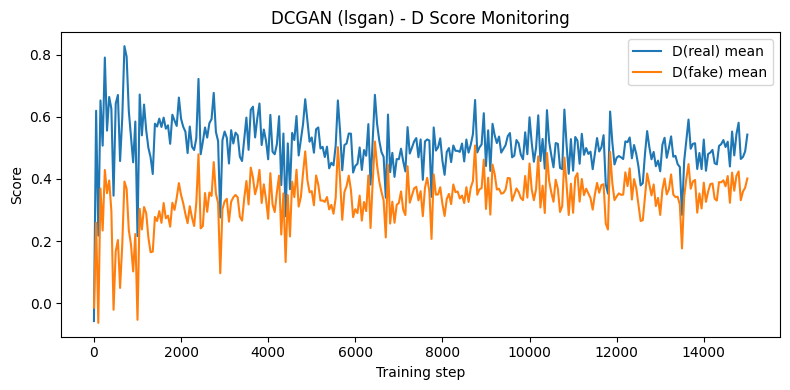


[lsgan] Evaluation summary:
  FID: 12.957 (lower better)
  KID: 13.093115 ± 13.733091 (lower better)
  Stability: std(loss_D)=0.0250 | std(loss_G)=0.0487 (lower better)
  Runtime: 4.19 min
Saved summary row: runs/dcgan_metrics_summary.csv

=== Training DCGAN | loss=hinge ===


DCGAN [hinge]:   0%|          | 3/15005 [00:00<08:20, 29.97it/s]

[hinge | step 0] Saved: samples/dcgan/hinge/step_000000.png


DCGAN [hinge]:   7%|▋         | 1009/15005 [00:17<03:55, 59.42it/s]

[hinge | step 1000] Saved: samples/dcgan/hinge/step_001000.png


DCGAN [hinge]:  13%|█▎        | 2009/15005 [00:34<03:51, 56.06it/s]

[hinge | step 2000] Saved: samples/dcgan/hinge/step_002000.png


DCGAN [hinge]:  20%|██        | 3012/15005 [00:50<03:21, 59.63it/s]

[hinge | step 3000] Saved: samples/dcgan/hinge/step_003000.png


DCGAN [hinge]:  27%|██▋       | 4011/15005 [01:06<03:10, 57.83it/s]

[hinge | step 4000] Saved: samples/dcgan/hinge/step_004000.png


DCGAN [hinge]:  33%|███▎      | 5012/15005 [01:22<02:37, 63.51it/s]

[hinge | step 5000] Saved: samples/dcgan/hinge/step_005000.png


DCGAN [hinge]:  40%|████      | 6010/15005 [01:38<02:44, 54.67it/s]

[hinge | step 6000] Saved: samples/dcgan/hinge/step_006000.png


DCGAN [hinge]:  47%|████▋     | 7010/15005 [01:55<02:06, 63.35it/s]

[hinge | step 7000] Saved: samples/dcgan/hinge/step_007000.png


DCGAN [hinge]:  53%|█████▎    | 8008/15005 [02:12<01:57, 59.39it/s]

[hinge | step 8000] Saved: samples/dcgan/hinge/step_008000.png


DCGAN [hinge]:  60%|██████    | 9006/15005 [02:29<01:36, 61.85it/s]

[hinge | step 9000] Saved: samples/dcgan/hinge/step_009000.png


DCGAN [hinge]:  67%|██████▋   | 10011/15005 [02:45<01:17, 64.41it/s]

[hinge | step 10000] Saved: samples/dcgan/hinge/step_010000.png


DCGAN [hinge]:  73%|███████▎  | 11009/15005 [03:01<01:08, 58.68it/s]

[hinge | step 11000] Saved: samples/dcgan/hinge/step_011000.png


DCGAN [hinge]:  80%|████████  | 12008/15005 [03:17<00:48, 61.33it/s]

[hinge | step 12000] Saved: samples/dcgan/hinge/step_012000.png


DCGAN [hinge]:  87%|████████▋ | 13010/15005 [03:34<00:33, 58.81it/s]

[hinge | step 13000] Saved: samples/dcgan/hinge/step_013000.png


DCGAN [hinge]:  93%|█████████▎| 14010/15005 [03:50<00:17, 57.60it/s]

[hinge | step 14000] Saved: samples/dcgan/hinge/step_014000.png


DCGAN [hinge]: 100%|██████████| 15005/15005 [04:07<00:00, 60.54it/s]

[hinge | step 15000] Saved: samples/dcgan/hinge/step_015000.png
Saved log: runs/dcgan_hinge_log.csv


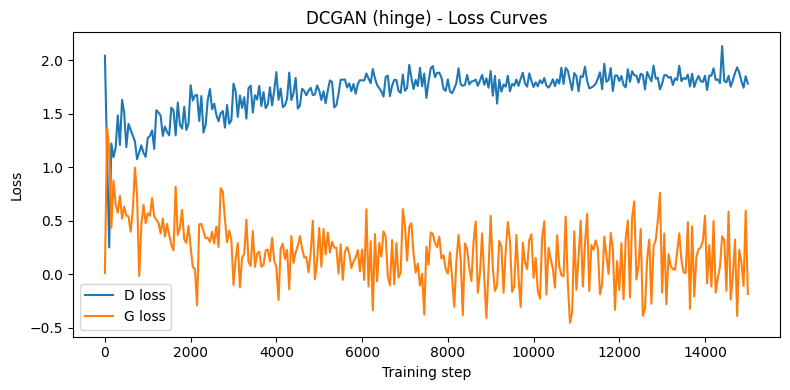

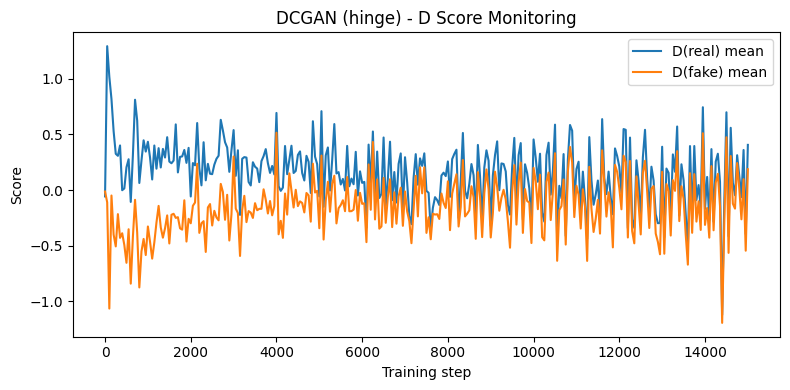


[hinge] Evaluation summary:
  FID: 7.934 (lower better)
  KID: 11.429639 ± 11.612947 (lower better)
  Stability: std(loss_D)=0.2075 | std(loss_G)=0.2809 (lower better)
  Runtime: 4.14 min
Saved summary row: runs/dcgan_metrics_summary.csv

=== Training DCGAN | loss=wgan-gp ===


DCGAN [wgan-gp]:   0%|          | 3/15005 [00:00<38:39,  6.47it/s]  

[wgan-gp | step 0] Saved: samples/dcgan/wgan-gp/step_000000.png


DCGAN [wgan-gp]:   7%|▋         | 1003/15005 [00:59<13:22, 17.45it/s]

[wgan-gp | step 1000] Saved: samples/dcgan/wgan-gp/step_001000.png


DCGAN [wgan-gp]:  13%|█▎        | 2003/15005 [01:58<14:33, 14.88it/s]

[wgan-gp | step 2000] Saved: samples/dcgan/wgan-gp/step_002000.png


DCGAN [wgan-gp]:  20%|██        | 3003/15005 [02:56<11:12, 17.84it/s]

[wgan-gp | step 3000] Saved: samples/dcgan/wgan-gp/step_003000.png


DCGAN [wgan-gp]:  27%|██▋       | 4003/15005 [03:52<10:55, 16.77it/s]

[wgan-gp | step 4000] Saved: samples/dcgan/wgan-gp/step_004000.png


DCGAN [wgan-gp]:  33%|███▎      | 5003/15005 [04:53<10:16, 16.21it/s]

[wgan-gp | step 5000] Saved: samples/dcgan/wgan-gp/step_005000.png


DCGAN [wgan-gp]:  40%|████      | 6003/15005 [05:51<09:03, 16.57it/s]

[wgan-gp | step 6000] Saved: samples/dcgan/wgan-gp/step_006000.png


DCGAN [wgan-gp]:  47%|████▋     | 7003/15005 [06:51<08:11, 16.29it/s]

[wgan-gp | step 7000] Saved: samples/dcgan/wgan-gp/step_007000.png


DCGAN [wgan-gp]:  53%|█████▎    | 8003/15005 [07:51<07:13, 16.15it/s]

[wgan-gp | step 8000] Saved: samples/dcgan/wgan-gp/step_008000.png


DCGAN [wgan-gp]:  60%|██████    | 9003/15005 [08:51<06:29, 15.39it/s]

[wgan-gp | step 9000] Saved: samples/dcgan/wgan-gp/step_009000.png


DCGAN [wgan-gp]:  67%|██████▋   | 10003/15005 [09:50<04:59, 16.71it/s]

[wgan-gp | step 10000] Saved: samples/dcgan/wgan-gp/step_010000.png


DCGAN [wgan-gp]:  73%|███████▎  | 11003/15005 [10:50<04:04, 16.39it/s]

[wgan-gp | step 11000] Saved: samples/dcgan/wgan-gp/step_011000.png


DCGAN [wgan-gp]:  80%|███████▉  | 12003/15005 [11:49<03:07, 16.01it/s]

[wgan-gp | step 12000] Saved: samples/dcgan/wgan-gp/step_012000.png


DCGAN [wgan-gp]:  87%|████████▋ | 13003/15005 [12:48<01:59, 16.73it/s]

[wgan-gp | step 13000] Saved: samples/dcgan/wgan-gp/step_013000.png


DCGAN [wgan-gp]:  93%|█████████▎| 14003/15005 [13:46<00:57, 17.30it/s]

[wgan-gp | step 14000] Saved: samples/dcgan/wgan-gp/step_014000.png


DCGAN [wgan-gp]: 100%|█████████▉| 15003/15005 [14:43<00:00, 17.71it/s]

[wgan-gp | step 15000] Saved: samples/dcgan/wgan-gp/step_015000.png


DCGAN [wgan-gp]: 100%|██████████| 15005/15005 [14:43<00:00, 16.98it/s]

Saved log: runs/dcgan_wgan-gp_log.csv


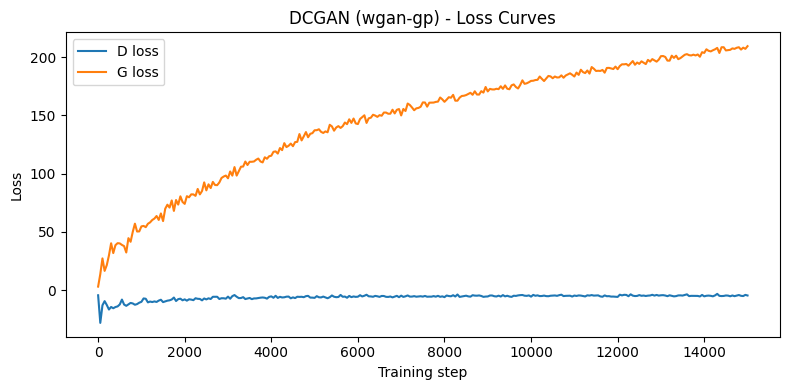

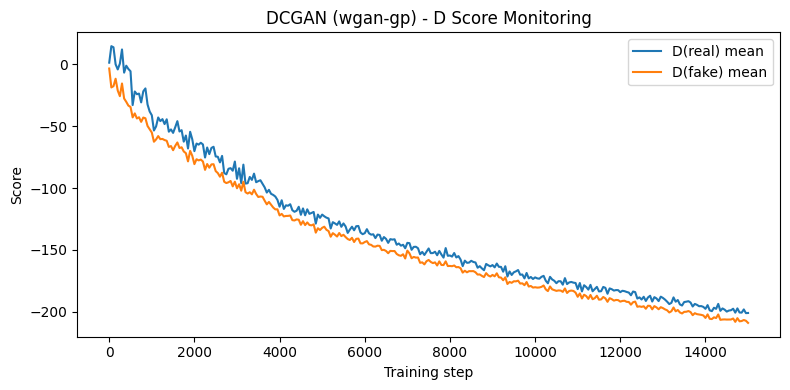

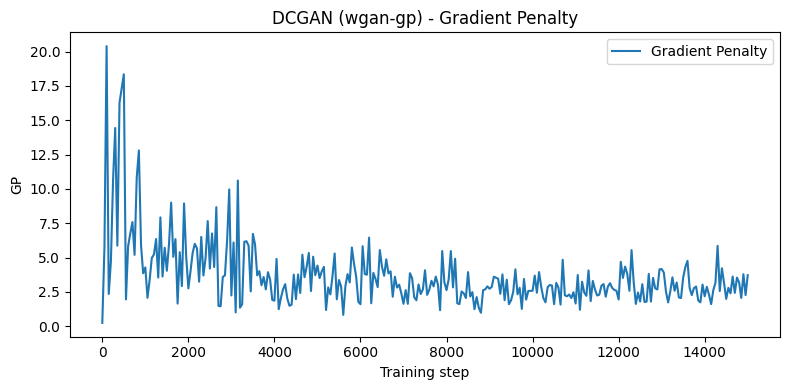


[wgan-gp] Evaluation summary:
  FID: 7.919 (lower better)
  KID: 19.737843 ± 8.786035 (lower better)
  Stability: std(loss_D)=2.5023 | std(loss_G)=50.4834 (lower better)
  Runtime: 14.73 min
Saved summary row: runs/dcgan_metrics_summary.csv
Saved generators for: ['bce', 'lsgan', 'hinge', 'wgan-gp']


In [22]:
# for t-SNE / diversity store final generators in memory
gens_by_loss = {}
logs_by_loss = {}

for lt in LOSS_SET:
    G_final, D_final, df_log = train_dcgan(lt)
    gens_by_loss[lt] = G_final
    logs_by_loss[lt] = df_log

print("Saved generators for:", list(gens_by_loss.keys()))


=== DCGAN ranking (best → worst) ===


loss_type        FID   KID_mean    KID_std  stability  runtime_sec
0   wgan-gp   7.919493  19.737843   8.786035  52.985609   884.065728
1     hinge   7.933537  11.429639  11.612947   0.488448   248.405015
2       bce   8.858090  11.363134  11.209501   0.192716   245.630473
3     lsgan  12.956653  13.093115  13.733091   0.073696   251.148799


BEST LOSS (by FID then KID): wgan-gp


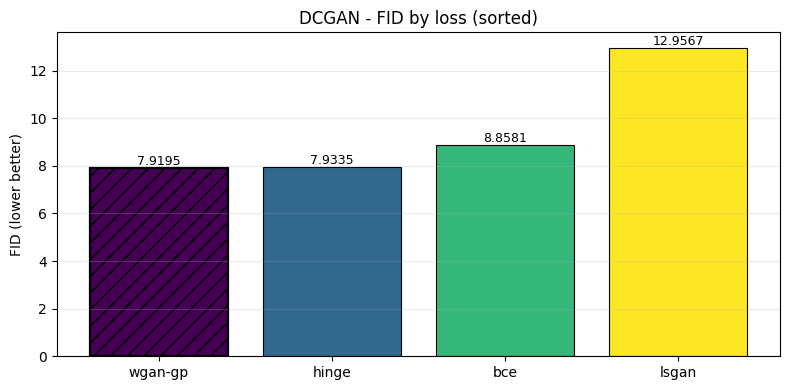

Best for FID (lower better): wgan-gp


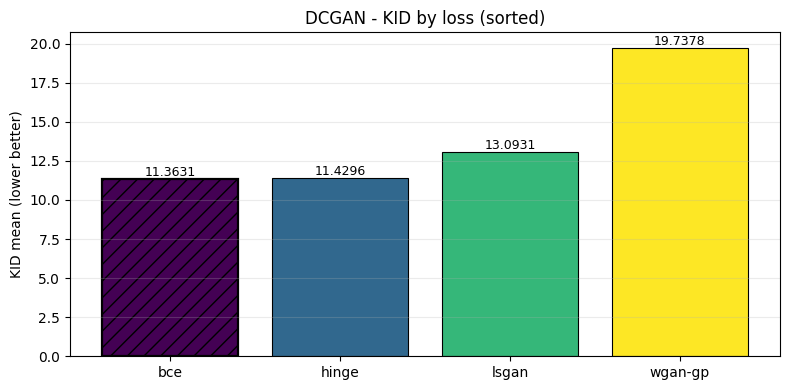

Best for KID_mean (lower better): bce


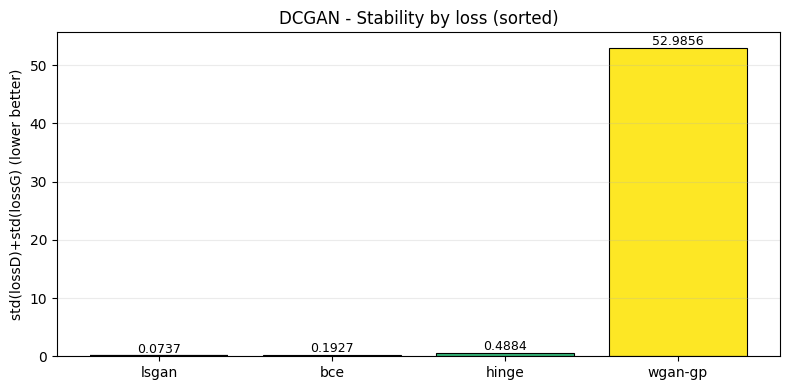

Best for stability (lower better): lsgan


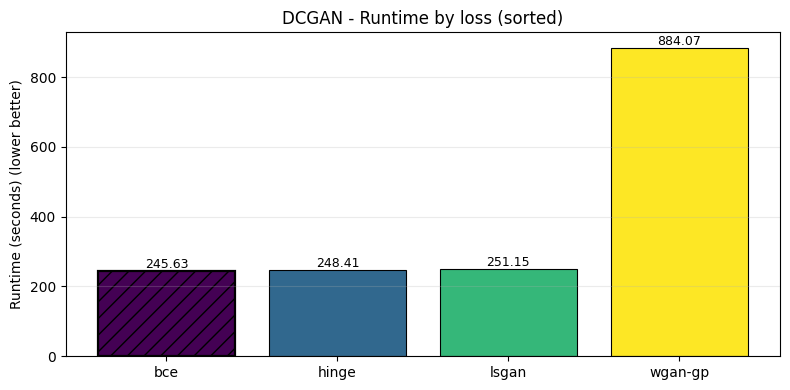

Best for runtime_sec (lower better): bce

BEST OVERALL (by FID then KID): wgan-gp


In [23]:
summary = pd.read_csv("runs/dcgan_metrics_summary.csv")
summary["stability"] = summary["lossD_std"] + summary["lossG_std"]

# Ranking: primary=FID, secondary=KID
ranked = summary.sort_values(["FID", "KID_mean"], ascending=True).reset_index(drop=True)

print("=== DCGAN ranking (best → worst) ===")
display(ranked[["loss_type", "FID", "KID_mean", "KID_std", "stability", "runtime_sec"]])

# ranking (best first)
ranked = summary.sort_values(["FID", "KID_mean"], ascending=True).reset_index(drop=True)
best_loss = ranked.loc[0, "loss_type"]

best_loss = ranked.loc[0, "loss_type"]
print(f"\nBEST LOSS (by FID then KID): {best_loss}")

def barplot_metric(df, metric, title, ylabel, lower_better=True):
    # order bars by metric (or inverse)
    dfp = df.sort_values(metric, ascending=lower_better).reset_index(drop=True)

    x = dfp["loss_type"].astype(str).tolist()
    y = dfp[metric].astype(float).to_numpy()

    # automatic colors via colormap (no manual colors)
    cmap = plt.get_cmap("viridis")
    colors = [cmap(i / max(1, len(x)-1)) for i in range(len(x))]

    plt.figure(figsize=(8, 4))
    bars = plt.bar(x, y, color=colors, edgecolor="black", linewidth=0.8)

    # highlight best (first bar after sorting)
    bars[0].set_hatch("//")
    bars[0].set_linewidth(1.6)

    # annotate values
    for b, val in zip(bars, y):
        plt.text(b.get_x() + b.get_width()/2, b.get_height(),
                 f"{val:.4f}" if abs(val) < 100 else f"{val:.2f}",
                 ha="center", va="bottom", fontsize=9)

    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

    print(f"Best for {metric} ({'lower' if lower_better else 'higher'} better): {dfp.loc[0,'loss_type']}")

# Plots
barplot_metric(ranked, "FID", "DCGAN - FID by loss (sorted)", "FID (lower better)", lower_better=True)
barplot_metric(ranked, "KID_mean", "DCGAN - KID by loss (sorted)", "KID mean (lower better)", lower_better=True)
barplot_metric(ranked, "stability", "DCGAN - Stability by loss (sorted)", "std(lossD)+std(lossG) (lower better)", lower_better=True)
barplot_metric(ranked, "runtime_sec", "DCGAN - Runtime by loss (sorted)", "Runtime (seconds) (lower better)", lower_better=True)

print("\nBEST OVERALL (by FID then KID):", best_loss)


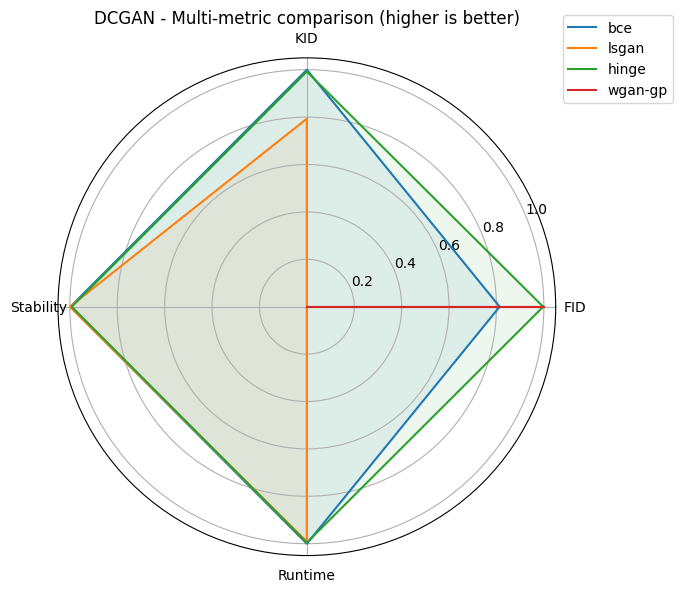

In [24]:
rad = summary.copy()
rad["stability"] = rad["lossD_std"] + rad["lossG_std"]

def minmax(x):
    x = x.astype(float)
    return (x - x.min()) / (x.max() - x.min() + 1e-12)

# invert because lower is better -> higher becomes better
rad["FID_n"] = 1.0 - minmax(rad["FID"])
rad["KID_n"] = 1.0 - minmax(rad["KID_mean"])
rad["STB_n"] = 1.0 - minmax(rad["stability"])
rad["RT_n"]  = 1.0 - minmax(rad["runtime_sec"])

labels = ["FID", "KID", "Stability", "Runtime"]
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate([angles, angles[:1]])

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

for _, row in rad.iterrows():
    vals = np.array([row["FID_n"], row["KID_n"], row["STB_n"], row["RT_n"]])
    vals = np.concatenate([vals, vals[:1]])
    ax.plot(angles, vals, label=row["loss_type"])
    ax.fill(angles, vals, alpha=0.08)

ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
ax.set_title("DCGAN - Multi-metric comparison (higher is better)")
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))
plt.tight_layout()
plt.show()


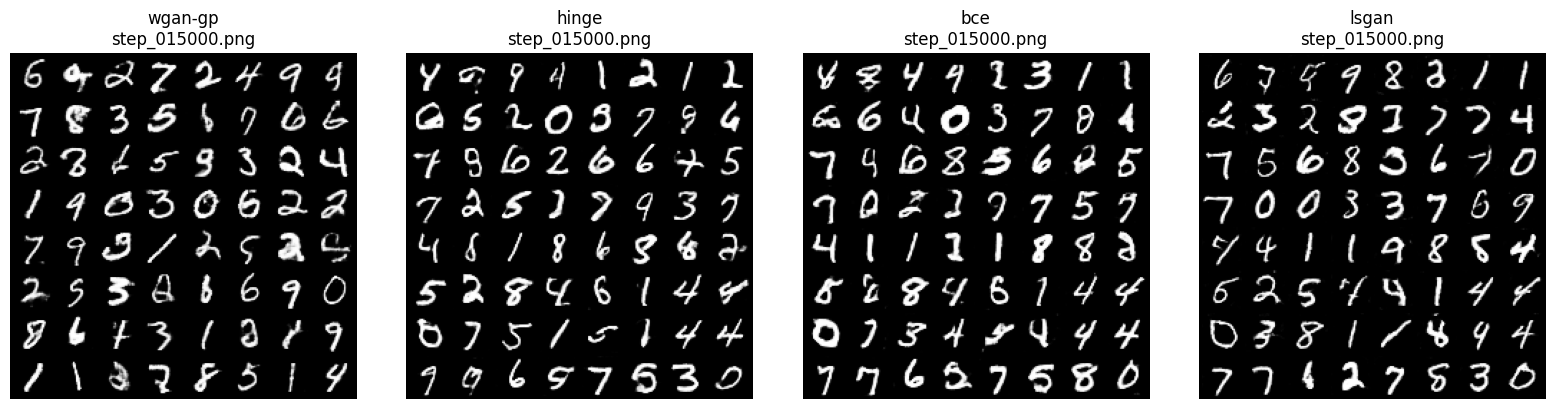

In [25]:
# =========================
# CELL 4 — Visual grids (final sample per loss)
# =========================
# This expects you saved samples per loss in: samples/dcgan/{loss_type}/step_XXXXXX.png
# If you currently saved all losses into the same folder, fix training to:
# out_dir=f"samples/dcgan/{loss_type}"
#
# It will load the LAST png in each loss folder and show them side-by-side.

import os, glob
from PIL import Image

def find_last_sample(loss_type, base_dir="samples/dcgan"):
    folder = os.path.join(base_dir, str(loss_type))
    if not os.path.isdir(folder):
        return None
    files = sorted(glob.glob(os.path.join(folder, "step_*.png")))
    return files[-1] if files else None

losses = ranked["loss_type"].astype(str).tolist()
paths = [(lt, find_last_sample(lt)) for lt in losses]

# filter missing
paths = [(lt, p) for lt, p in paths if p is not None]
if len(paths) == 0:
    print("No per-loss sample folders found. Save samples to: samples/dcgan/{loss_type}/step_XXXXXX.png")
else:
    n = len(paths)
    plt.figure(figsize=(4*n, 4))
    for i, (lt, p) in enumerate(paths, start=1):
        img = Image.open(p)
        ax = plt.subplot(1, n, i)
        ax.imshow(img)
        ax.set_title(f"{lt}\n{os.path.basename(p)}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


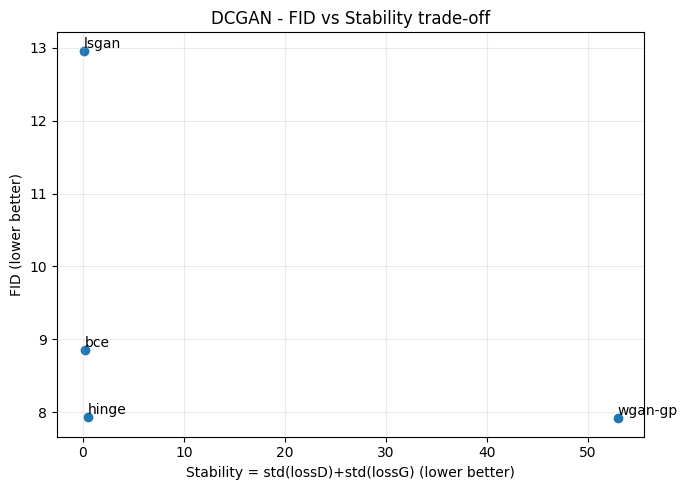

In [26]:
# =========================
# CELL 5 — Scatter: FID vs Stability (trade-off)
# =========================
import matplotlib.pyplot as plt

df = ranked.copy()
df["stability"] = df["lossD_std"].astype(float) + df["lossG_std"].astype(float)

plt.figure(figsize=(7, 5))
plt.scatter(df["stability"], df["FID"])

for _, r in df.iterrows():
    plt.text(r["stability"], r["FID"], str(r["loss_type"]), fontsize=10, ha="left", va="bottom")

plt.xlabel("Stability = std(lossD)+std(lossG) (lower better)")
plt.ylabel("FID (lower better)")
plt.title("DCGAN - FID vs Stability trade-off")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


In [27]:
# =========================
# CELL 1 — Setup helpers: embeddings (real/fake) using your feature_net
# =========================
import numpy as np
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def collect_real_embeddings(feature_net, train_loader, device, n_samples=5000):
    """
    Returns:
      feats: (N, D) numpy
      labels: (N,) numpy
    train_loader yields images in [-1,1]; we convert to [0,1] for feature_net.
    """
    feature_net.eval()
    feats_list, labs_list = [], []
    seen = 0

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        x = (x * 0.5 + 0.5).clamp(0, 1)

        feats, _ = feature_net(x)  # feats: [B, D]
        feats_list.append(feats.cpu())
        labs_list.append(y.cpu())

        seen += x.size(0)
        if seen >= n_samples:
            break

    feats = torch.cat(feats_list, dim=0)[:n_samples].numpy()
    labels = torch.cat(labs_list, dim=0)[:n_samples].numpy()
    return feats, labels


@torch.no_grad()
def collect_fake_embeddings(feature_net, G, device, latent_dim, n_samples=5000, batch_size=512):
    """
    Returns:
      feats: (N, D) numpy
    G outputs in [-1,1]; we convert to [0,1] for feature_net.
    """
    feature_net.eval()
    G_was_training = G.training
    G.eval()

    feats_list = []
    seen = 0
    while seen < n_samples:
        bs = min(batch_size, n_samples - seen)
        z = torch.randn(bs, latent_dim, 1, 1, device=device)
        fake = G(z)
        fake = (fake * 0.5 + 0.5).clamp(0, 1)

        feats, _ = feature_net(fake)
        feats_list.append(feats.cpu())

        seen += bs

    if G_was_training:
        G.train()

    feats = torch.cat(feats_list, dim=0).numpy()
    return feats


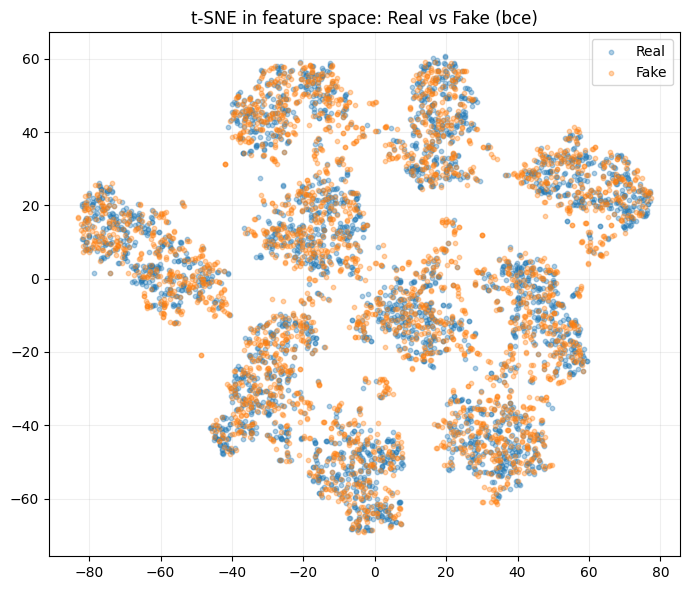

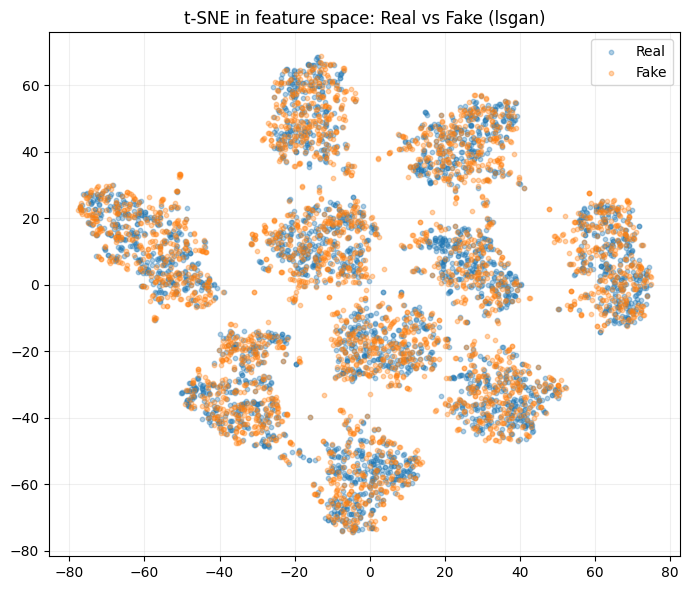

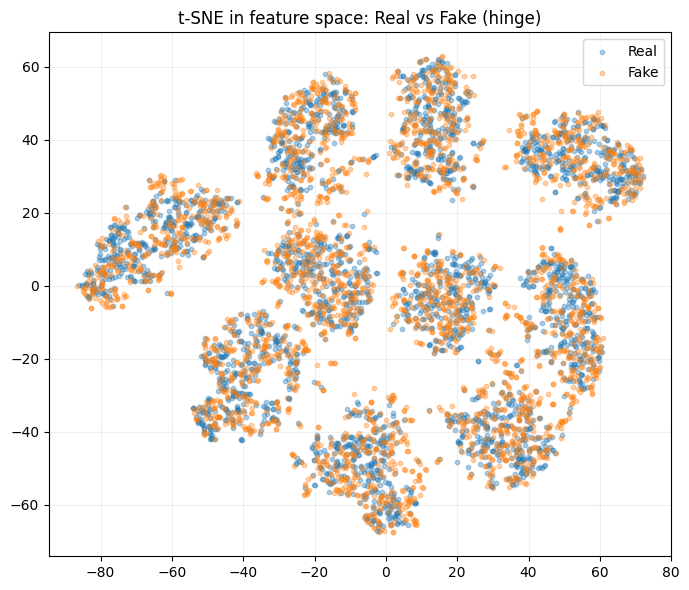

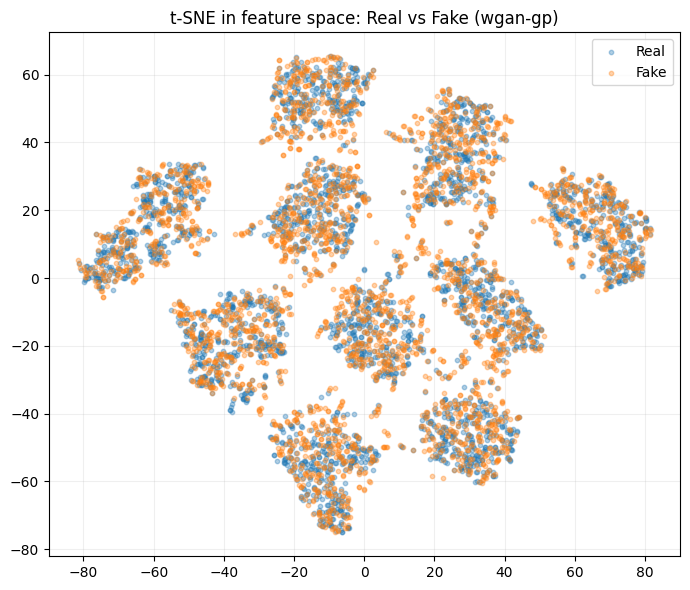

In [28]:
# =========================
# CELL 2 — t-SNE (real vs fake) in feature space (per loss)
# =========================
# Install note: sklearn is usually available; if not, you need to install scikit-learn.
from sklearn.manifold import TSNE

N_TSNE_REAL = 3000
N_TSNE_FAKE = 3000
TSNE_PERPLEXITY = 30
TSNE_SEED = 42

# 1) Real embeddings (shared)
real_feats, real_labels = collect_real_embeddings(feature_net, train_loader, device, n_samples=N_TSNE_REAL)

# 2) Fake embeddings per loss (you need a trained generator per loss)
# If you didn't keep G objects, reload them from checkpoints. Otherwise, pass your trained Gs.
# Example assumes you kept final Gs in a dict: gens_by_loss = {"bce": G_bce, ...}

def tsne_plot_real_vs_fake(real_feats, fake_feats, title):
    X = np.vstack([real_feats, fake_feats])
    y_domain = np.array([0]*len(real_feats) + [1]*len(fake_feats))  # 0=real,1=fake

    tsne = TSNE(n_components=2, perplexity=TSNE_PERPLEXITY, random_state=TSNE_SEED, init="pca", learning_rate="auto")
    Z = tsne.fit_transform(X)

    plt.figure(figsize=(7, 6))
    plt.scatter(Z[y_domain==0, 0], Z[y_domain==0, 1], s=10, alpha=0.35, label="Real")
    plt.scatter(Z[y_domain==1, 0], Z[y_domain==1, 1], s=10, alpha=0.35, label="Fake")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

# ---- Run for each loss ----
# IMPORTANT: you need the trained G for each loss here.
# Option A: if you trained sequentially and still have the returned G, do:
#   G_bce, _, _ = train_dcgan("bce")
#   G_lsgan, _, _ = train_dcgan("lsgan") ...
# Then set:
# gens_by_loss = {"bce": G_bce, "lsgan": G_lsgan, ...}

# Example placeholder:
# gens_by_loss = {...}

for lt, G_model in gens_by_loss.items():
    fake_feats = collect_fake_embeddings(feature_net, G_model, device, LATENT_DIM, n_samples=N_TSNE_FAKE)
    tsne_plot_real_vs_fake(real_feats, fake_feats, title=f"t-SNE in feature space: Real vs Fake ({lt})")


In [29]:
### Gif

In [30]:
import imageio
import glob
import os

def make_gif_from_samples(
    samples_dir="samples/dcgan",
    out_gif="dcgan_training.gif",
    fps=2
):
    files = sorted(glob.glob(os.path.join(samples_dir, "step_*.png")))
    
    if len(files) == 0:
        raise RuntimeError(f"No images found in {samples_dir}")

    print(f"Found {len(files)} frames.")

    with imageio.get_writer(out_gif, mode="I", fps=fps) as writer:
        for f in files:
            img = imageio.imread(f)
            writer.append_data(img)

    print(f"GIF saved to: {out_gif}")

make_gif_from_samples(
    samples_dir="samples/dcgan",
    out_gif="dcgan_training.gif",
    fps=2
)


Found 16 frames.
GIF saved to: dcgan_training.gif


/tmp/ipykernel_48205/2677613199.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(f)


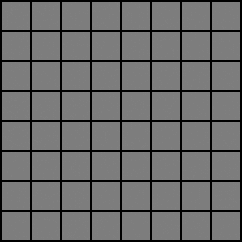

In [31]:
from IPython.display import Image, display

display(Image(filename="dcgan_training.gif"))

